# Important Frequencies Selection

## Import Libraries and seed
Import the necessary libraries for data processing, model building, training, and evaluation. Adding a seed ensures reproducibility by making sure that the random number generation is consistent across different runs.

In [ ]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


import wandb

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    return seed

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Set seed for reproducibility
seed = set_seed(42)



Using device: cpu


In [4]:
def load_data_from_directory(input_path):
    data_frames = []
    for file in os.listdir(input_path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(input_path, file), delimiter=';', header=0)
            data_frames.append(df)
    data = pd.concat(data_frames, ignore_index=True)

    return data

## Preprocessing Data
Define a function to preprocess the data. This includes encoding categorical labels and standardizing the features.

In [32]:
def calculate_averages_and_dispersion(data, data_percentage):
    df = data
    results = []
    for (sample, freq), group in df.groupby(['Sample', 'Frequency (GHz)']):
        window_size = max(1, int(len(group) * data_percentage / 100))
        # print(f"Processing sample: {sample}, frequency: {freq} with window size: {window_size}")
        for start in range(0, len(group), window_size):
            window_data = group.iloc[start:start + window_size]
            mean_values = window_data[['LG (mV)', 'HG (mV)']].mean()
            std_deviation_values = window_data[['LG (mV)', 'HG (mV)']].std()
            results.append({
                'Frequency (GHz)': freq,
                'LG (mV) mean': mean_values['LG (mV)'],
                'HG (mV) mean': mean_values['HG (mV)'],
                'LG (mV) std deviation': std_deviation_values['LG (mV)'],
                'HG (mV) std deviation': std_deviation_values['HG (mV)'],
                # 'Thickness (mm)': window_data['Thickness (mm)'].iloc[0], ## COMMENT
                'Sample': sample,
            })
    results_df = pd.DataFrame(results)
    # results_df.to_csv(output_file, sep=';', index=False)
    # print(f"Processed {input_file} and saved to {output_file}")
    # print(results_df)
    return results_df

## Pivoting Frequency values to columns

In [31]:
def freq_as_variable(df, data_percentage):
    '''Modify df to have Frequency values (100,110,120 and so on) as and input variables in the columns'''

    # Remove Thickness column
    if 'Thickness (mm)' in df.columns:
        df = df.drop(columns=['Thickness (mm)'])

    # 1s window_size 100/27s = 3.7% of the data is used for each window
    df_window = calculate_averages_and_dispersion(df, data_percentage) 

    # Add a unique identifier column to avoid duplicate entries in the index
    df_window['unique_id'] = df_window.groupby(['Sample', 'Frequency (GHz)']).cumcount()

    # Pivot the DataFrame to wide format
    df_pivot = df_window.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')

    # Flatten the MultiIndex columns
    df_pivot.columns = [' '.join(map(str, col)) for col in df_pivot.columns]

    # Drop columns with all NaN values
    df_pivot = df_pivot.dropna(axis=1, how='all')

    # Reset index to make 'Sample' and 'unique_id' columns again
    df_pivot = df_pivot.reset_index()

    # Optional - Sort the columns if needed
    df_pivot = df_pivot.reindex(sorted(df_pivot.columns), axis=1)

    # Remove 'unique_id' column
    df_pivot = df_pivot.drop(columns=['unique_id'])

    return df_pivot

In [12]:
# Load the data from the directory
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test/'
df = load_data_from_directory(input_path)

df = pd.concat([df[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df[['Sample']]], axis=1)

df.head()

,Frequency (GHz),LG (mV),HG (mV),Sample
0,100.0,-7.080942,-0.854611,A1
1,100.0,67.024785,0.244141,A1
2,100.0,124.893178,-1.098776,A1
3,100.0,91.075571,0.000000,A1
4,100.0,48.956174,0.122094,A1


## Sample a test set

In [42]:
train_set, test_set = train_test_split(df, test_size=0.15, random_state=42, stratify=df['Sample'])

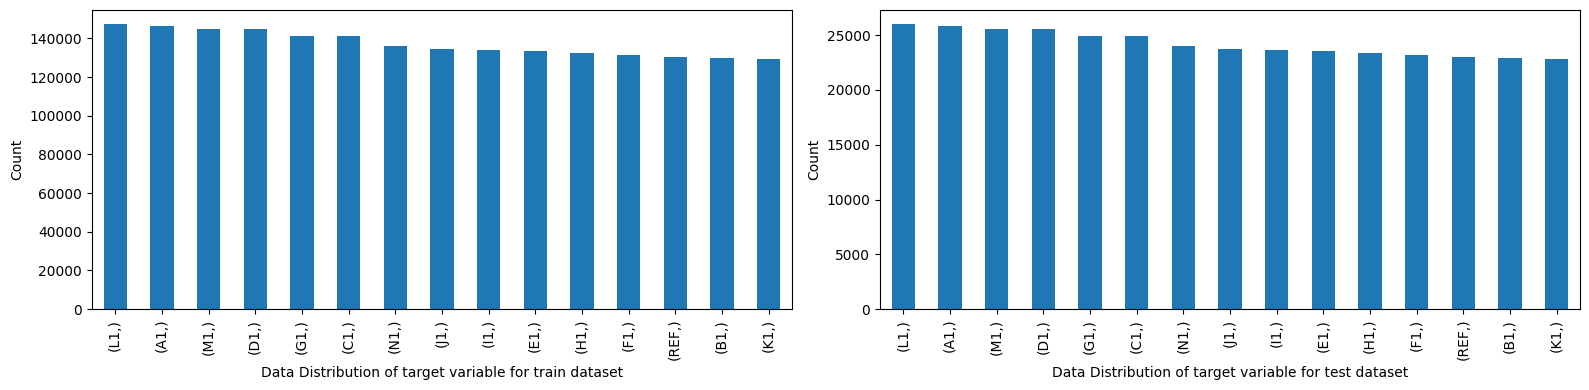

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# Plot train set
train_set[['Sample']].value_counts().plot.bar(ax=ax[0], legend=False)
ax[0].set_xlabel('Data Distribution of target variable for train dataset')
ax[0].set_ylabel('Count')

# Plot test set
test_set[['Sample']].value_counts().plot.bar(ax=ax[1], legend=False)
ax[1].set_xlabel('Data Distribution of target variable for test dataset')
ax[1].set_ylabel('Count')

plt.tight_layout() 
plt.show()

In [44]:
train_ex = train_set.copy()

In [45]:
train_ex.info()
# train_ex.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 2057531 entries, 802810 to 1961991
Data columns (total 4 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Frequency (GHz)  float64
 1   LG (mV)          float64
 2   HG (mV)          float64
 3   Sample           object 
dtypes: float64(3), object(1)
memory usage: 78.5+ MB


In [46]:
train_ex['Sample'].nunique()

15

In [47]:
# Introduce Frequency values as input variables
train_set_test = freq_as_variable(train_set, data_percentage=0.5)
test_set_test = freq_as_variable(test_set, data_percentage=0.5)
train_set_test.head()
test_set_test.head()

# Save the processed data to a CSV file
# output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test.csv'
# df.to_csv(output_path, sep = ';', index=False)



,HG (mV) mean 100.0,HG (mV) mean 110.0,HG (mV) mean 120.0,HG (mV) mean 130.0,HG (mV) mean 140.0,HG (mV) mean 150.0,HG (mV) mean 160.0,HG (mV) mean 170.0,HG (mV) mean 180.0,HG (mV) mean 190.0,...,LG (mV) std deviation 520.0,LG (mV) std deviation 530.0,LG (mV) std deviation 540.0,LG (mV) std deviation 550.0,LG (mV) std deviation 560.0,LG (mV) std deviation 570.0,LG (mV) std deviation 580.0,LG (mV) std deviation 590.0,LG (mV) std deviation 600.0,Sample
0,0.488305,-0.366247,-0.183118,0.488341,-0.976682,-0.427258,-0.427270,0.000000,-0.366258,-0.305211,...,0.776946,2.330836,NaN,0.172654,0.863273,0.863273,0.172654,0.345309,1.391985,A1
1,0.122070,-0.549376,-1.037717,1.220858,-0.122118,-0.061047,-0.305223,0.732530,0.610435,0.854599,...,0.690618,0.431636,NaN,0.517964,1.381237,0.776946,1.899200,0.172655,0.863273,A1
2,0.366259,0.122094,-0.183141,0.183130,0.061035,-0.549376,0.061048,-0.793540,0.061059,-0.305176,...,0.086328,0.172655,NaN,1.122255,1.122255,0.172655,0.863273,0.086327,1.009697,A1
3,-0.854564,1.342917,0.244164,-0.122035,0.549364,0.305235,0.244153,-0.244176,-0.366270,-1.098752,...,0.345309,0.863273,NaN,0.000000,0.604291,1.899200,1.381236,0.000000,1.694157,A1
4,0.122023,-0.854612,-0.122094,-0.305188,-0.305211,-0.183141,-0.671458,-0.244153,-0.244140,0.183130,...,0.172654,0.345309,NaN,0.258982,1.899200,0.776946,0.690618,2.417164,0.829521,A1


## Login in Weights & Biases

In [26]:
###
### SKIP FOR NOW ###
###

%env WANDB_API_KEY=94b4debef3cc9601df4d91995649548f8ab3a097
wandb.login()

# wandb.init(project='PIC-PAPER-01', entity='UC3M', name='RandomForest')
# wandb.watch(rf_model)

env: WANDB_API_KEY=94b4debef3cc9601df4d91995649548f8ab3a097


True

# Prepare Training Data
## Split the data into X and y


In [117]:
# Split the data into X and y
X_train = train_set_test.drop(columns=['Sample'])
y_train = train_set_test['Sample']

X_test = test_set_test.drop(columns=['Sample'])
y_test = test_set_test['Sample']

# Encode the target variable if it's categorical
if y_train.dtype == 'object':
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)

if y_test.dtype == 'object':
    y_test = le.transform(y_test)

# le is the fitted LabelEncoder - Saving Encoder
joblib.dump(le, 'label_encoder.pkl')

print('y_train:', y_train)

# # Convert to PyTorch tensors
# X_groups = torch.tensor(X_groups, dtype=torch.float32)
# y_groups = torch.tensor(y_groups, dtype=torch.long)

y_train: [ 0  0  0 ... 14 14 14]


## Prepare new sample for testing

In [118]:
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_2_plastics/processed/test/'
df_new_sample = load_data_from_directory(input_path)
df_new_sample = pd.concat([df_new_sample[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df_new_sample[['Sample']]], axis=1)

# Add .0 on every Frequency column value to match the format of the training data
df_new_sample['Frequency (GHz)'] = df_new_sample['Frequency (GHz)'].astype(str) + '.0'
print('X_new_sample:', df_new_sample)

df_new_sample = freq_as_variable(df_new_sample, data_percentage=0.22) # 0.22

X_new_sample = df_new_sample.drop(columns=['Sample'])
y_new_sample = df_new_sample['Sample']

if y_new_sample.dtype == 'object':
    y_new_sample = le.transform(y_new_sample)

print('X_new_sample:', X_new_sample)
print('y_new_sample:', y_new_sample)


X_new_sample:       Frequency (GHz)    LG (mV)    HG (mV) Sample
0               100.0  31.375900  -0.610423     E1
1               100.0  27.469173  -0.244117     E1
2               100.0  46.758637  -0.244164     E1
3               100.0  93.883531   0.488353     E1
4               100.0  82.163350  -0.488377     E1
...               ...        ...        ...    ...
70927           600.0   0.610426  36.381394     E1
70928           600.0   0.122085   9.400561     E1
70929           600.0   0.732511  32.596752     E1
70930           600.0  -0.122085  29.422536     E1
70931           600.0   0.000000  13.307288     E1

[70932 rows x 4 columns]
X_new_sample:      HG (mV) mean 100.0  HG (mV) mean 110.0  HG (mV) mean 120.0  \
0             -0.427270           -1.098775           -0.061011   
1              0.122094            0.732482            0.488341   
2             -0.061048           -1.037729            0.549364   
3              0.061035           -0.122106           -0.671447   

## Train Model

In [119]:
# Model Parameters
input_size = X_train.shape[1]
output_size = len(np.unique(y_train))
seed = set_seed(42)

# print(f'input_size: {input_size}, output_size: {output_size}')
# print(X_train, y_train)

# Define Random Forest model
rf_model = RandomForestClassifier(n_estimators=10, criterion= 'gini' , random_state=seed)

# # Define Naive-Bayes model
# nb_model = GaussianNB()

# # Define Logistic Regression model
# lr_model = LogisticRegression(max_iter=1000, random_state = seed)


# Train model using wandb for metrics
# TBD 

# Train the model
rf_model.fit(X_train, y_train)


# Predictions
# y_pred = rf_model.predict(X_test)
y_pred = rf_model.predict(X_new_sample)
y_test_original = y_test.copy()
y_test = y_new_sample

# # Create a DataFrame to compare
# df_comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# print(df_comparison.head(10))

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

# Classification report
print(classification_report(y_test, y_pred), )

# Predictions made per class with its label encoded value
print(Counter(y_pred))

# Feature importance (Find 10 most important variables with its name and importance value)
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)
print(feature_importances_df.head(25))





# Log metrics wandb
# wandb.log({"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1})






Accuracy: 0.7066869300911854
Precision: 1.0
Recall: 0.7066869300911854
F1: 0.8281389136242209
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       1.00      0.71      0.83       658
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0

    accuracy                           0.71       658
   macro avg       0.11      0.08      0.09       658
weighted avg       1.00      0.71      0.83       658

Counter({4: 465, 0: 67, 11: 58, 10: 26, 14: 22, 3: 14, 6: 4, 12: 1, 7: 1})
                         Feature  Importance
27            HG (mV) mean 370.0    0.045736
28            HG (mV) mean 380.0    

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

## Confusion Matrix

C:\Users\Danim\AppData\Local\Temp\ipykernel_11980\1660825651.py:13: RuntimeWarning: invalid value encountered in scalar divide
  plt.text(j, i, f'{conf_matrix[i, j]}\n({conf_matrix[i, j] / np.sum(conf_matrix, axis=1)[i] * 100:.1f}%)',


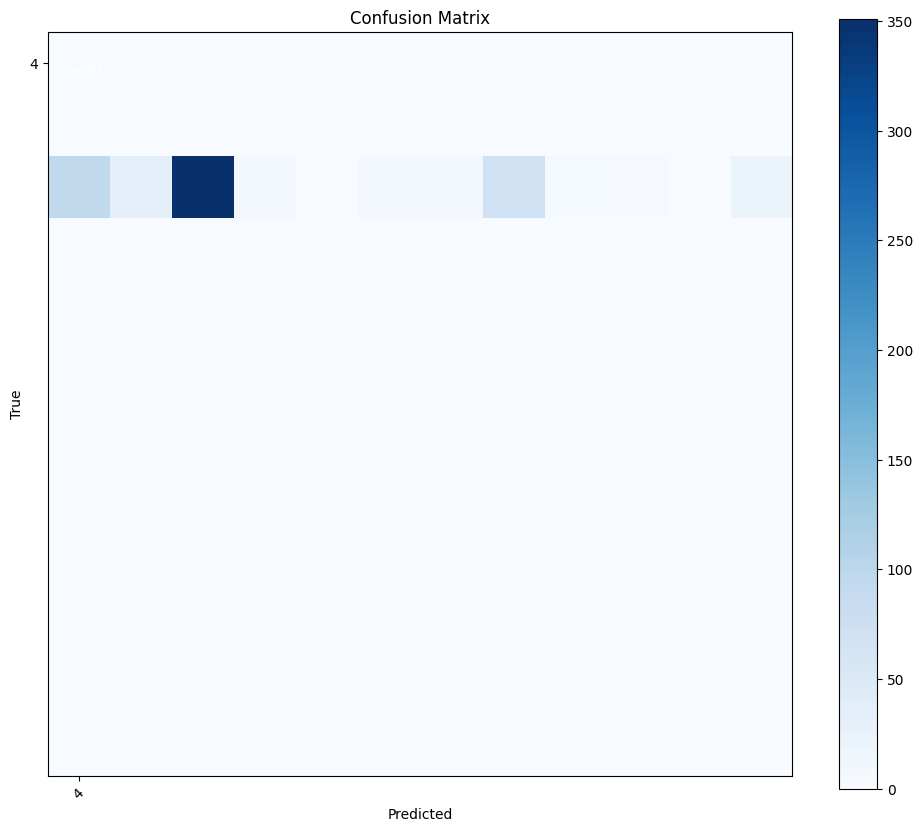

In [ ]:
# Confusion matrix with matplotlib
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(np.unique(y_test_original))), np.unique(y_test_original), rotation=45)
plt.yticks(np.arange(len(np.unique(y_test_original))), np.unique(y_test_original))
plt.ylabel('True')
plt.xlabel('Predicted')
for i in range(len(np.unique(y_test))):
    for j in range(len(np.unique(y_test))):
        plt.text(j, i, f'{conf_matrix[i, j]}\n({conf_matrix[i, j] / np.sum(conf_matrix, axis=1)[i] * 100:.1f}%)',
                horizontalalignment="center",
                verticalalignment="center",
                fontsize=9,
                ha='center', va='center', color='white')
plt.show()

## Load and preprocess Other Test Data (Experiment 2)

In [ ]:
#TBD

In [ ]:
# ## Confusion Matrix
# conf_matrix = confusion_matrix(le.inverse_transform(y_test.cpu().numpy()), predicted_labels, labels=le.classes_)

# # Confusion matrix with matplotlib
# plt.figure(figsize=(12, 10))
# plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.colorbar()
# tick_marks = np.arange(len(le.classes_))
# plt.xticks(tick_marks, le.classes_, rotation=45)
# plt.yticks(tick_marks, le.classes_)

# # Normalize the confusion matrix
# conf_matrix_normalized = np.nan_to_num(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis])

# # Print the normalized values inside the matrix as percentages
# thresh = conf_matrix.max() / 2.
# for i, j in np.ndindex(conf_matrix.shape):
#     plt.text(j, i, f"{conf_matrix[i, j]}\n ({conf_matrix_normalized[i, j] * 100:.1f}%)",
#              horizontalalignment="center",
#              verticalalignment="center",
#              fontsize=9,
#              color="white" if conf_matrix[i, j] > thresh else "black")

# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.tight_layout()

## Feature Importance TBD

## Labels

| Original Label | Encoded Value |
|----------------|---------------|
| A1             | 0             |
| B1             | 1             |
| C1             | 2             |
| D1             | 3             |
| E1             | 4             |
| F1             | 5             |
| G1             | 6             |
| H1             | 7             |
| I1             | 8             |
| J1             | 9             |
| K1             | 10            |
| L1             | 11            |
| M1             | 12            |
| N1             | 13            |
| REF            | 14            |